## Use logistic regression to classify young stellar objects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Read the YSO classification file for YSOs from Gutermuth et al. 2009 (G09)
# Table 4 in G09, full data available online

df_yso = pd.read_csv("table4_Gutermuth09.csv", comment='#', header=0)

print(df_yso.shape)
df_yso.head()


(2548, 11)


,Jmag,Hmag,Ksmag,3.6mag,4.5mag,5.8mag,8.0mag,24mag,AKs,alpha,Cl
0,15.1,14.3,13.92,13.27,NaN,12.34,NaN,6.82,0.10,NaN,I*
1,NaN,NaN,13.84,11.34,10.05,8.99,8.10,4.34,NaN,0.87,I
2,NaN,NaN,14.98,11.90,10.76,9.96,9.28,NaN,NaN,0.12,I
3,NaN,15.0,12.86,10.52,9.61,8.84,7.97,NaN,1.92,0.08,I
4,NaN,NaN,NaN,14.22,13.20,12.09,11.36,NaN,NaN,0.48,I


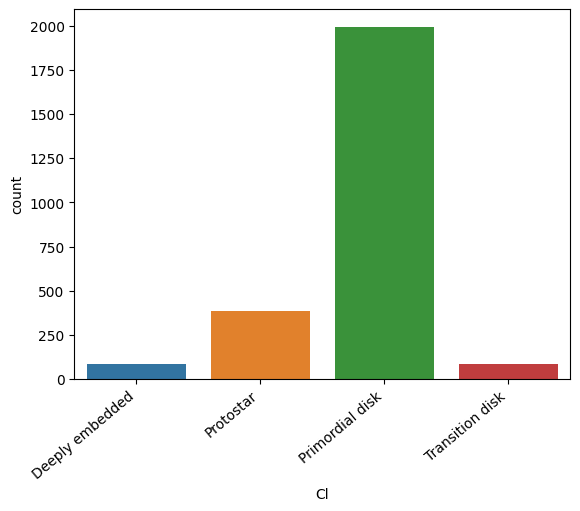

In [3]:
# Visualize different YSO classes
ax = sns.countplot(x=df_yso['Cl'])
ax.set_xticklabels(["Deeply embedded", "Protostar", "Primordial disk", "Transition disk",], rotation=40, ha="right")
plt.tight_layout
plt.show()

In [4]:
# Create a binary classification of YSO: class 0 and 1 represented by class 1; and class 2 and 3 represented by class 2
df_yso.loc[((df_yso["Cl"] == 'I*') | (df_yso["Cl"] == 'I')), "YSO"] = "I"
df_yso.loc[((df_yso["Cl"] == 'II*') | (df_yso["Cl"] == 'II')), "YSO"] = "II"


In [5]:
# Check the new column
df_yso.head()

,Jmag,Hmag,Ksmag,3.6mag,4.5mag,5.8mag,8.0mag,24mag,AKs,alpha,Cl,YSO
0,15.1,14.3,13.92,13.27,NaN,12.34,NaN,6.82,0.10,NaN,I*,I
1,NaN,NaN,13.84,11.34,10.05,8.99,8.10,4.34,NaN,0.87,I,I
2,NaN,NaN,14.98,11.90,10.76,9.96,9.28,NaN,NaN,0.12,I,I
3,NaN,15.0,12.86,10.52,9.61,8.84,7.97,NaN,1.92,0.08,I,I
4,NaN,NaN,NaN,14.22,13.20,12.09,11.36,NaN,NaN,0.48,I,I


In [6]:
# Get information of the dataframe
df_yso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2548 entries, 0 to 2547
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Jmag    1675 non-null   float64
 1   Hmag    1970 non-null   float64
 2   Ksmag   2132 non-null   float64
 3   3.6mag  2523 non-null   float64
 4   4.5mag  2522 non-null   float64
 5   5.8mag  2381 non-null   float64
 6   8.0mag  2203 non-null   float64
 7   24mag   1274 non-null   float64
 8   AKs     1937 non-null   float64
 9   alpha   2171 non-null   float64
 10  Cl      2548 non-null   object 
 11  YSO     2548 non-null   object 
dtypes: float64(10), object(2)
memory usage: 239.0+ KB


### Missing values
##### We employ a multiple-copula imputation. The algorithm decomposes joint probability distributions into their marginal distributions and a function, the copula, that couples them (Nelsen 2010). Previous tests suggest that this method outperforms other popular approaches, such as multiple imputation via chained equations (van Buuren & Groothuis-Oudshoorn 2011) and Amelia (Honaker et al. 2011), in terms of bias and coverage, especially in cases where the variables are not normally distributed (Hoff 2007). The underlying idea of copula imputation is to derive conditional density functions of the missing variables given the observed ones through the corresponding conditional copulas, and then impute missing values by drawing observations from them.

In [7]:
from gcimpute.gaussian_copula import GaussianCopula

In [8]:
# Define a Gaussian Copula model and fit with data containing missing values
model = GaussianCopula()
Ximp = model.fit_transform(X=df_yso.iloc[:,:-2].values)
Ximp = np.around(Ximp , 1)

In [9]:
df_yso.iloc[:,:-2] = Ximp

In [10]:
df_yso.head(4)

,Jmag,Hmag,Ksmag,3.6mag,4.5mag,5.8mag,8.0mag,24mag,AKs,alpha,Cl,YSO
0,15.1,14.3,13.9,13.3,12.8,12.3,11.5,6.8,0.1,-0.9,I*,I
1,16.5,15.3,13.8,11.3,10.0,9.0,8.1,4.3,1.9,0.9,I,I
2,17.5,16.4,15.0,11.9,10.8,10.0,9.3,5.4,3.5,0.1,I,I
3,16.5,15.0,12.9,10.5,9.6,8.8,8.0,4.0,1.9,0.1,I,I


### Extract the copula correlation estimates to see which variables are correlated

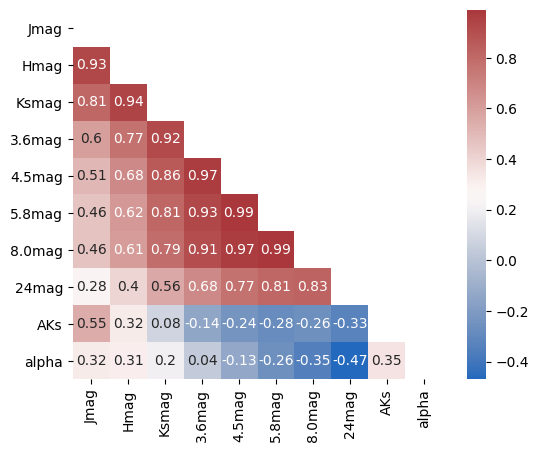

In [11]:
copula_corr_est = model.get_params()['copula_corr']
mask = np.zeros_like(copula_corr_est)
mask[np.triu_indices_from(mask)] = True
names = df_yso.columns[:-2]
fig = sns.heatmap(np.round(copula_corr_est,2), 
                  xticklabels=names, yticklabels=names, 
                  annot=True, mask=mask, square=True, cmap='vlag')
plt.show()

###### From the above correlation diagram, the IRAC mid-IR bands are the most correlated variables.

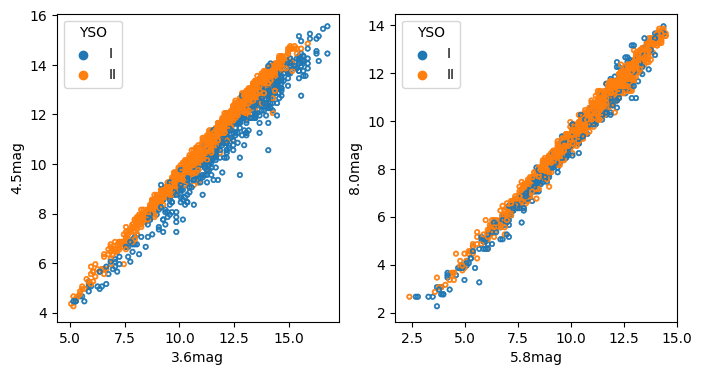

In [12]:
f, axes = plt.subplots(1, 2, figsize=(8,4))
sns.scatterplot(x = "3.6mag", y = "4.5mag", hue="YSO", data=df_yso, marker="$\circ$", ec="face", ax=axes[0])
sns.scatterplot(x = "5.8mag", y = "8.0mag", hue="YSO", data=df_yso, marker="$\circ$", ec="face", ax=axes[1])
plt.show()

### Data Engineering
###### A crucial stage of ML is engineering the data so that the target variable is more predictive using a new set of variables. In stellar astronomy, the magnitudes themselves are less predictive than their differences, aka color.

In [13]:
# Magnitude columns whose differences we seek to compute
cols_eng = df_yso.columns[:-4]
print(cols_eng)

Index(['Jmag', 'Hmag', 'Ksmag', '3.6mag', '4.5mag', '5.8mag', '8.0mag',
       '24mag'],
      dtype='object')


In [14]:
# Make new columns using every possible combination of differences of flux columns
# Important: 1) Do not repeat columns 2) Two columns should not be the same when calculating difference
for i in range(len(cols_eng)-1):
    for j in range(len(cols_eng)-1):
        if j >= i:
            hdr = cols_eng[i] + "-" + cols_eng[j+1]
            df_yso[hdr] = df_yso[cols_eng[i]] - df_yso[cols_eng[j+1]]
    

In [15]:
# Check columns and whether all differences are correctly calculated
df_yso.columns

Index(['Jmag', 'Hmag', 'Ksmag', '3.6mag', '4.5mag', '5.8mag', '8.0mag',
       '24mag', 'AKs', 'alpha', 'Cl', 'YSO', 'Jmag-Hmag', 'Jmag-Ksmag',
       'Jmag-3.6mag', 'Jmag-4.5mag', 'Jmag-5.8mag', 'Jmag-8.0mag',
       'Jmag-24mag', 'Hmag-Ksmag', 'Hmag-3.6mag', 'Hmag-4.5mag', 'Hmag-5.8mag',
       'Hmag-8.0mag', 'Hmag-24mag', 'Ksmag-3.6mag', 'Ksmag-4.5mag',
       'Ksmag-5.8mag', 'Ksmag-8.0mag', 'Ksmag-24mag', '3.6mag-4.5mag',
       '3.6mag-5.8mag', '3.6mag-8.0mag', '3.6mag-24mag', '4.5mag-5.8mag',
       '4.5mag-8.0mag', '4.5mag-24mag', '5.8mag-8.0mag', '5.8mag-24mag',
       '8.0mag-24mag'],
      dtype='object')

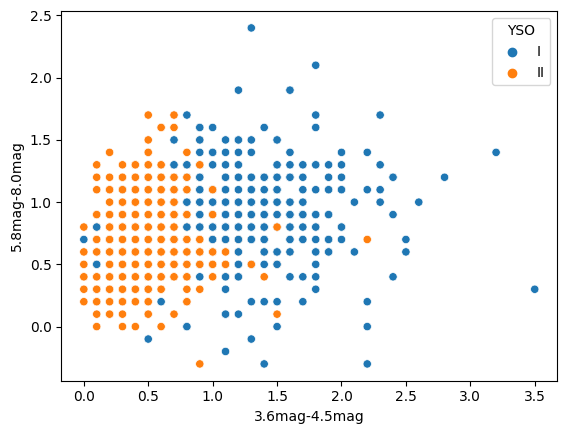

In [16]:
# Some EDA
sns.scatterplot(x="3.6mag-4.5mag", y="5.8mag-8.0mag", data=df_yso, hue="YSO")
plt.show()

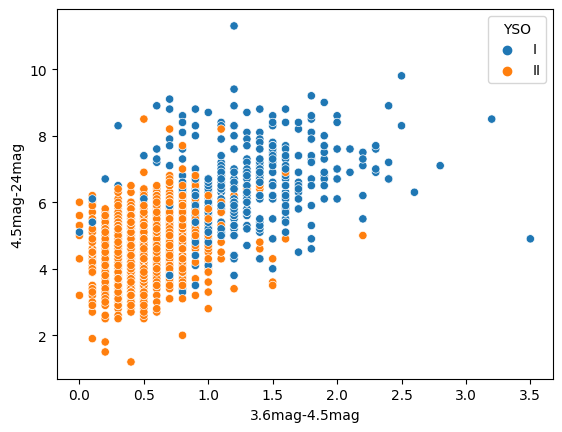

In [17]:
sns.scatterplot(x="3.6mag-4.5mag", y="4.5mag-24mag", data=df_yso, hue="YSO")
plt.show()

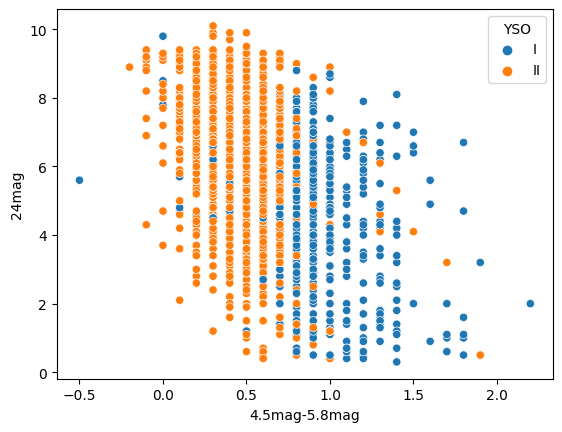

In [18]:
sns.scatterplot(x="4.5mag-5.8mag", y="24mag", data=df_yso, hue="YSO")
plt.show()

###### In our quick analysis, we see that the MIR colors such as 3.6-4.5, 5.8-8.0 and 4.5-24 are strong predictors of YSO class

### Splitting the data into training and testing sets

In [19]:
# Check columns that need to included for features and label
df_yso.columns

Index(['Jmag', 'Hmag', 'Ksmag', '3.6mag', '4.5mag', '5.8mag', '8.0mag',
       '24mag', 'AKs', 'alpha', 'Cl', 'YSO', 'Jmag-Hmag', 'Jmag-Ksmag',
       'Jmag-3.6mag', 'Jmag-4.5mag', 'Jmag-5.8mag', 'Jmag-8.0mag',
       'Jmag-24mag', 'Hmag-Ksmag', 'Hmag-3.6mag', 'Hmag-4.5mag', 'Hmag-5.8mag',
       'Hmag-8.0mag', 'Hmag-24mag', 'Ksmag-3.6mag', 'Ksmag-4.5mag',
       'Ksmag-5.8mag', 'Ksmag-8.0mag', 'Ksmag-24mag', '3.6mag-4.5mag',
       '3.6mag-5.8mag', '3.6mag-8.0mag', '3.6mag-24mag', '4.5mag-5.8mag',
       '4.5mag-8.0mag', '4.5mag-24mag', '5.8mag-8.0mag', '5.8mag-24mag',
       '8.0mag-24mag'],
      dtype='object')

In [20]:
# Features
X = df_yso.drop(labels=['Cl', 'YSO'], axis=1).values

# Target (dependent variable)
y = df_yso["YSO"].values
y

array(['I', 'I', 'I', ..., 'II', 'II', 'II'], dtype=object)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1911, 38) (637, 38) (1911,) (637,)


### Feature scaling
##### IMPORTANT to apply feature scaling only AFTER doing train-test split. If done beforehand it may lead to information leakage.

In [22]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [23]:
print(X_train)

[[ 0.5202345   0.61407566  0.31724825 ...  0.55495199  0.52521984
   0.39971   ]
 [ 0.24039209  0.44961263  0.70449432 ... -1.03621569 -0.12421084
   0.16848681]
 [ 0.46426602  0.44961263  0.53853172 ...  0.55495199  0.52521984
   0.39971   ]
 ...
 [-0.20735575 -0.04377649  0.20660651 ...  1.35053583 -0.44892618
  -0.87201755]
 [ 1.19185627  1.6556749   1.58962822 ... -0.63842377  1.06641207
   1.32460276]
 [-0.31929271 -0.20823952  0.0406439  ...  0.15716007  0.30874295
   0.2840984 ]]


In [24]:
print(X_test)

[[ 0.85604538  1.05264376  1.14706127 ...  2.94170351  3.33941943
   2.7119419 ]
 [-0.3752612  -0.26306054 -0.06999783 ...  0.15716007 -0.77364151
  -0.87201755]
 [ 0.63217146  0.83335971  0.81513606 ...  0.95274391  1.49936585
   1.32460276]
 ...
 [ 0.57620298  0.72371769  0.75981519 ... -0.63842377  0.09226605
   0.2840984 ]
 [-0.6551036  -0.5371656  -0.34660218 ... -0.63842377 -1.2065953
  -1.10324074]
 [ 0.74410842  0.55925465  0.70449432 ...  0.15716007  0.52521984
   0.51532159]]


## Training the Logistic Regression model on the Training set

In [25]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)


LogisticRegression(random_state=0)

In [26]:
# Predict test results
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[['I' 'I']
 ['II' 'II']
 ['I' 'I']
 ...
 ['II' 'II']
 ['II' 'II']
 ['II' 'II']]


In [27]:
# Make confusion matrix to assess model performance
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 92  16]
 [  9 520]]


0.9607535321821036

In [28]:
# Percentage of false positives and false negatives
fp = np.around(cm[0,1] / len(y_test) * 100, 1)
fn = np.around(cm[1,0] / len(y_test) * 100, 1)
print(fp, fn)

2.5 1.4


#### Using a simple linear regressor, we obtain 96% accuracy. False positive (Type I error) is 2.5% and False negative (Type II error) is 1.4%.